# TOP NZ CLOTHING FACEBOOK PAGE ANALYSIS
List of top brands obtained from https://theculturetrip.com/pacific/new-zealand/articles/top-10-new-zealand-fashion-designers-you-should-know/

Among these 10 brands, random 3 brands are analysed to answer the following questions:

- ** How many people are engaging with these brands? **
    - For each brand, we will extract the number of reactions (which includes 'likes'), shares, comments given in each post. Then compare these data with other brands.
    - We also need to measure, how many percentage of the total fans for these brands are engaging in these posts. This relative data is measured upon diving previous step data with total fans in each page.
    
- ** What kind of posts are been shared in these brands? **
    - For each brand, we will first extract messages from each posts, then analyse frequency of words in these messages, finally identify the top N words that will summarize the type of message been shared with people.

- ** How frequent and at what time these posts are created by these brands? **
    - We will extract the post creation time which will be in `%Y-%M-%D %H:%M:%S` format. Then from each post `%Y-%M-%D` will be used to find post frequency and `%H` will be used to find the time at which these posts are created.




### IMPORTING REQUIRED PACKAGES 

In [1]:
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from string import punctuation
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Below line will enable IPython to show the  matplotlib plots in a notebook cell rather than in another window.
%matplotlib inline

### SETTINGS FOR THE APPLICATION

**`GRAPH_API_VERSION`** is the Facebook Graph API Version that needs to be used. Currently, `Version 2.10` is latest one.

**`NO_OF_POSTS`** is the number of posts that needs to be extracted from each brand.

**`BRAND_LIST`** is the list of brands that need to be analysed. Unique page name of each brands are stored. Example: For **Working Style**, https://www.facebook.com/workingstylenz is the facebook page and `workingstylenz` is the unique page name that need to be stored in this list.

**`ACCESS_TOKEN`** is obtained from https://developers.facebook.com/tools/explorer/

In [2]:
GRAPH_API_VERSION = "2.10"
NO_OF_POSTS = 10
BRAND_LIST = ["workingstylenz", "Companyofstrangersface", "myboyfriendsback"]
ACCESS_TOKEN = ''

### REQUEST AND RETRIEVE JSON DATA FROM FACEBOOK API USING ACCESS TOKEN

In [3]:
# 'page' can be id(unique number) or or name(unique name) of the page
def get_content(page, fields):

    base_url = 'https://graph.facebook.com/v{0}/{1}'.format(GRAPH_API_VERSION, page)
    url = '{0}?fields={1}&access_token={2}'.format(base_url, fields, ACCESS_TOKEN)

    response = urlopen(url).read().decode('utf-8')
    json_response = json.loads(response)
    return json_response

### GET BRAND NAME FOR A GIVEN PAGE

In [4]:
def brand_name(page_name):
    fields = 'name'
    json_response = get_content(page_name, fields)
    
    return json_response[fields]

### GET THE TOP N RECENT POSTS FOR A GIVEN PAGE

Here **`N`** will be the value given in **`NO_OF_POSTS`**

In [5]:
def recent_posts(page_name):    
    fields = 'posts'
    json_response = get_content(page_name, fields)

    posts = json_response["posts"]["data"]
    
    while len(posts) < NO_OF_POSTS:
        try:
            response = urlopen(json_response['paging']['next']).read().decode('utf-8')
            json_response = json.loads(response)
            posts.extend(json_response["posts"]["data"])
        except:
            print('No more Posts...')
            break
            
    if len(posts) > NO_OF_POSTS:
        posts = posts[:NO_OF_POSTS]
    
    return post_content(posts)


def post_content(posts):
    posts_id = [post["id"] if "id" in post
                else "" 
                for post in posts]
    
    posts_created_time = [post["created_time"] if "created_time" in post
                          else "" 
                          for post in posts]
    
    posts_message = [post["message"].replace('\n', ' ') if "message" in post 
                     else post["story"].replace('\n', ' ') if "story" in post 
                     else "" 
                     for post in posts]
    
    return posts_id, posts_created_time, posts_message

### GET NUMBER OF FANS FOR A GIVEN PAGE

In [6]:
def fan_count(page_name):
    fields = 'fan_count'
    json_response = get_content(page_name, fields)
    
    return json_response[fields]

### GET INSIGHT ABOUT A POST FOR A GIVEN POST ID

Extract the **`number of reactions, shares and comments`** in the post.

In [7]:
def post_insight(post_id):
    fields = 'shares,reactions.limit(0).summary(true),comments.limit(0).summary(true)'
    json_response = get_content(post_id, fields)
    
    reaction_count = json_response["reactions"]["summary"]["total_count"] if "reactions" in json_response else 0
    shares_count = json_response["shares"]["count"] if "shares" in json_response else 0
    comments_count = json_response["comments"]["summary"]["total_count"] if "comments" in json_response else 0
    
    return reaction_count, shares_count, comments_count

### GET THE RELATIVE COUNT

Relative count (will generated for reactions, shares and comments) is the percentage of number of reactions, shares or comments to total fans in a page.

In [8]:
def relative_count(count, total_count):
    return count / total_count * 100.0

### GENERATE A DATAFRAME FOR A GIVEN PAGE

Dataframe will have data about:
- Page Name
- Total Fans liked this page
- Post Number which will be from 1 to NO_OF_POSTS
- Post ID is the unique ID for each post
- Post Creation Date
- Post Message
- Number of Reactions in each post
- Number of Shares in each post
- Number of Comments in each post
- Relative Reaction Score for a post
- Relative Shares Score for a post
- Relative Comments Score for a post

In [9]:
def get_dataframe(page_name):
    total_fans = fan_count(page_name)
    name = brand_name(page_name)
    posts_id, posts_time, posts_message = recent_posts(page_name)

    reaction_count, shares_count, comments_count = [], [], []
    relative_reaction_count, relative_shares_count, relative_comments_count = [], [], []

    for id in posts_id:
        reactions, shares, comments = post_insight(id)
        reaction_count.append(reactions)
        shares_count.append(shares)
        comments_count.append(comments)

    for count in reaction_count:
        relative_value = relative_count(count, total_fans)
        relative_reaction_count.append(relative_value)

    for count in shares_count:
        relative_value = relative_count(count, total_fans)
        relative_shares_count.append(relative_value)

    for count in comments_count:
        relative_value = relative_count(count, total_fans)
        relative_comments_count.append(relative_value)

    data = dict((("Name", name),
                 ("Total Fans", total_fans),
                 ("Post Number", range(1, NO_OF_POSTS+1)),
                 ("Post ID", posts_id),
                 ("Post Date", posts_time),
                 ("Message", posts_message),
                 ("Reactions", reaction_count),
                 ("Shares", shares_count),
                 ("Comments", comments_count),
                 ("Rel. Reactions", relative_reaction_count),
                 ("Rel. Shares", relative_shares_count),
                 ("Rel. Comments", relative_comments_count),
            ))

    df = pd.DataFrame(data)
    df["Post Date"] = pd.to_datetime(df["Post Date"])

    return df

### GENERATE DATAFRAME OF ALL PAGES

In [10]:
df = pd.DataFrame() 

for brand in BRAND_LIST:
    df_brand = get_dataframe(brand)
    df = pd.concat([df, df_brand])

df = df.set_index(["Name", "Post Number"])
df = df.unstack(level=0)

### GENERATE BAR GRAPH OF TOTAL FANS IN EACH BRAND

Below result shows that **Working Style is more popular** as it has more number of fans when compared with other brands - **Company of Strangers and My Boyfriends Back**.

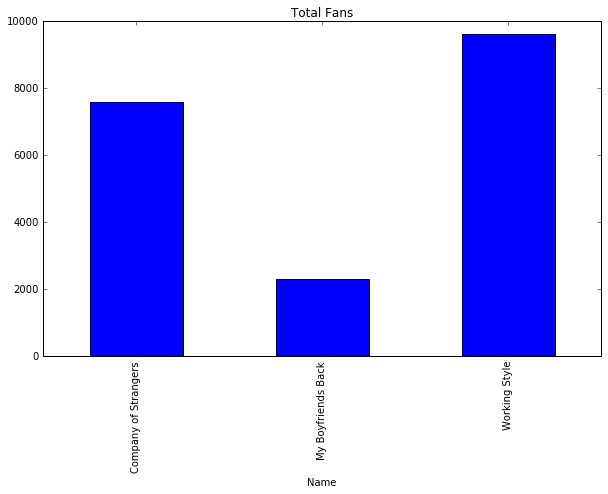

In [11]:
df['Total Fans'].mean().plot(kind='bar', title="Total Fans", figsize=(10, 6))

### COMPARE REACTIONS AND RELATIVE REACTIONS

If we consider the number of reactions in each posts, **Working Style** seems to have more reactions than the other brands as it has more number of fans.

But if we consider the relative count (percentage of users actually engaging in a given set of user), **My Boyfriends Back** seems better engaging users when compared with other brands.

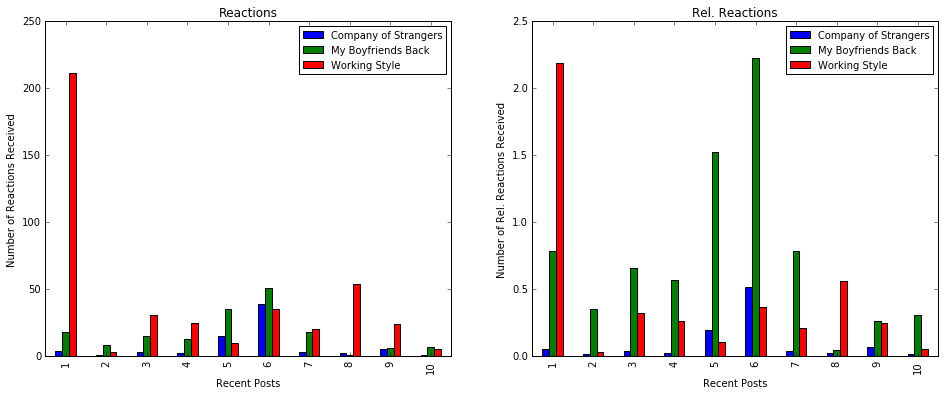

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_1 = df['Reactions'].plot(ax=ax[0], kind='bar', title="Reactions")
plot_1.set_xlabel('Recent Posts')
plot_1.set_ylabel('Number of Reactions Received')
plot_1.legend(prop={'size':10})

plot_2 = df['Rel. Reactions'].plot(ax=ax[1], kind='bar', title="Rel. Reactions")
plot_2.set_xlabel('Recent Posts')
plot_2.set_ylabel('Number of Rel. Reactions Received')
plot_2.legend(prop={'size':10})

### ANALYSE RELATIVE COUNT

Below Bar charts clearly shows that **My Boyfriends Back** has users who are more engaging (in terms of reacting, sharing and commenting in post) compared with other brands.

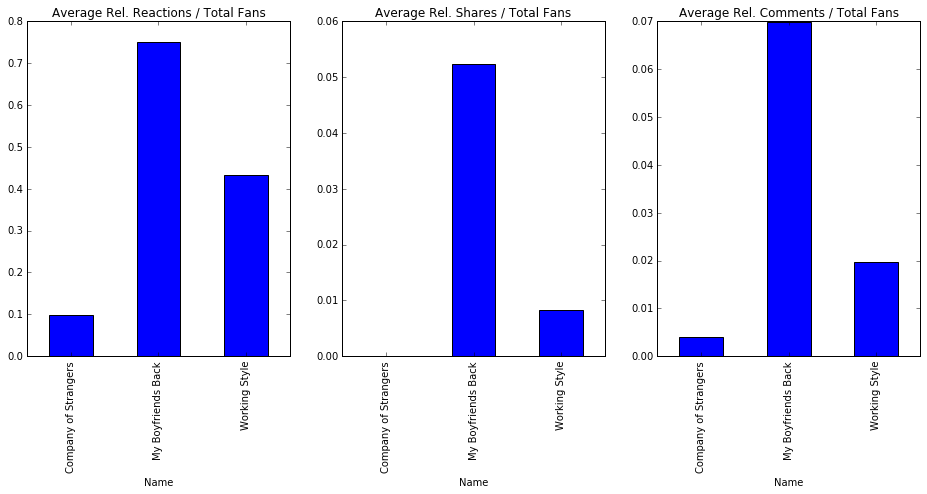

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

plot_1 = df['Rel. Reactions'].mean().plot(ax=ax[0], kind='bar', title='Average Rel. Reactions / Total Fans')
plot_2 = df['Rel. Shares'].mean().plot(ax=ax[1], kind='bar', title='Average Rel. Shares / Total Fans')
plot_3 = df['Rel. Comments'].mean().plot(ax=ax[2], kind='bar', title='Average Rel. Comments / Total Fans')

### FREQUENT WORDS USED IN POST

From the below table, we can see that most of the posts has external link ( as the table has keywords such as `https, //shop.companyofstrangers.co.nz, wstyle.nz`) which make sense, as these brands are trying to get traffic to their site through social media.

**NOTE** : By default Top 10 words will be returned, to change the number of words returned, edit the `TOP_N_WORDS` value.

In [14]:
TOP_N_WORDS = 10

df_message = df["Message"]

top_words = {}

special_words = ["'s", '...', '💚', '💜', '💛', 'xx', "'re", ]
filter_words = set(stopwords.words('english') + list(punctuation) + special_words)

for column in df_message.columns:
    result = {}
    for i in range(1, NO_OF_POSTS+1):
        word_list = word_tokenize(df_message[column][i].lower())
        nonstopword_list = [word for word in word_list if word not in filter_words]
        word_freq = FreqDist(nonstopword_list)
        for key in word_freq.keys():
            result[key] = result[key] + word_freq[key] if key in result else word_freq[key]
    top_words[column] = sorted(result, key=result.get, reverse=True)[:TOP_N_WORDS]

pd.DataFrame(top_words, index=range(1, TOP_N_WORDS+1))

,Company of Strangers,My Boyfriends Back,Working Style
1,https,https,new
2,company,emerson,made
3,strangers,hatton,black
4,store,lucinda,store
5,aw17,photography,tie
6,sweater,makeup,learn
7,one,boutique,wstyle.nz/tlrmde
8,available,york,http
9,//shop.companyofstrangers.co.nz/collections/co...,willis,wool
10,cos,louise,tailor


### HOW FREQUENT POSTS ARE CREATED

Below line graph shows that **Company of Strangers** frequently create post in social media (Last 10 posts were created approx. in 1 week). 

**My Boyfriends Back** has really good engaging users even if they are not creating posts frequently (Last 10 posts were created approx. more than a month) which gives a point of view that users wont usually engage with the page that frequently post or advertise their site in Facebook. 

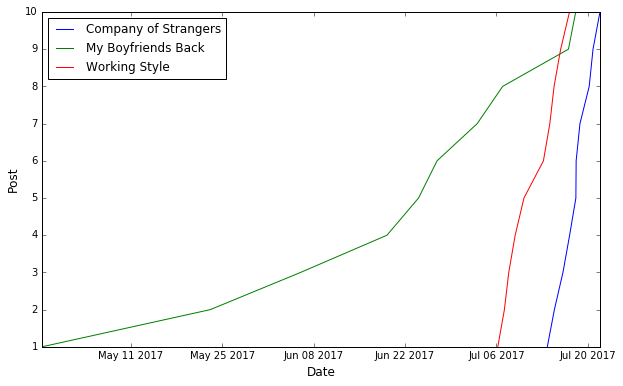

In [15]:
df_datetime = df["Post Date"].sort_values("Company of Strangers", ascending=True)
plt.figure(figsize=(10, 6))
plt.plot(df_datetime, df.index)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Post', fontsize=12)
# plt.xticks(rotation='vertical')
plt.legend(df_datetime.columns, loc="upper left")

### WHEN POSTS ARE CREATED

Most of the posts created by these brands are during non-working hours as people wont usually use Facebook at their working hours.

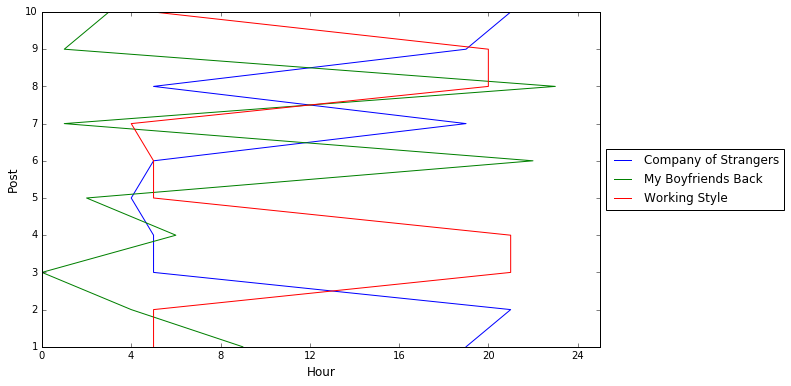

In [16]:
plt.figure(figsize=(10, 6))
for i in range(len(df_datetime.columns)):
    plt.plot(df_datetime[df_datetime.columns[i]].dt.hour, df.index)
plt.xticks(np.arange(0, 25, 4))
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Post', fontsize=12)
plt.legend(df_datetime.columns, loc='center left', bbox_to_anchor=(1, 0.5))